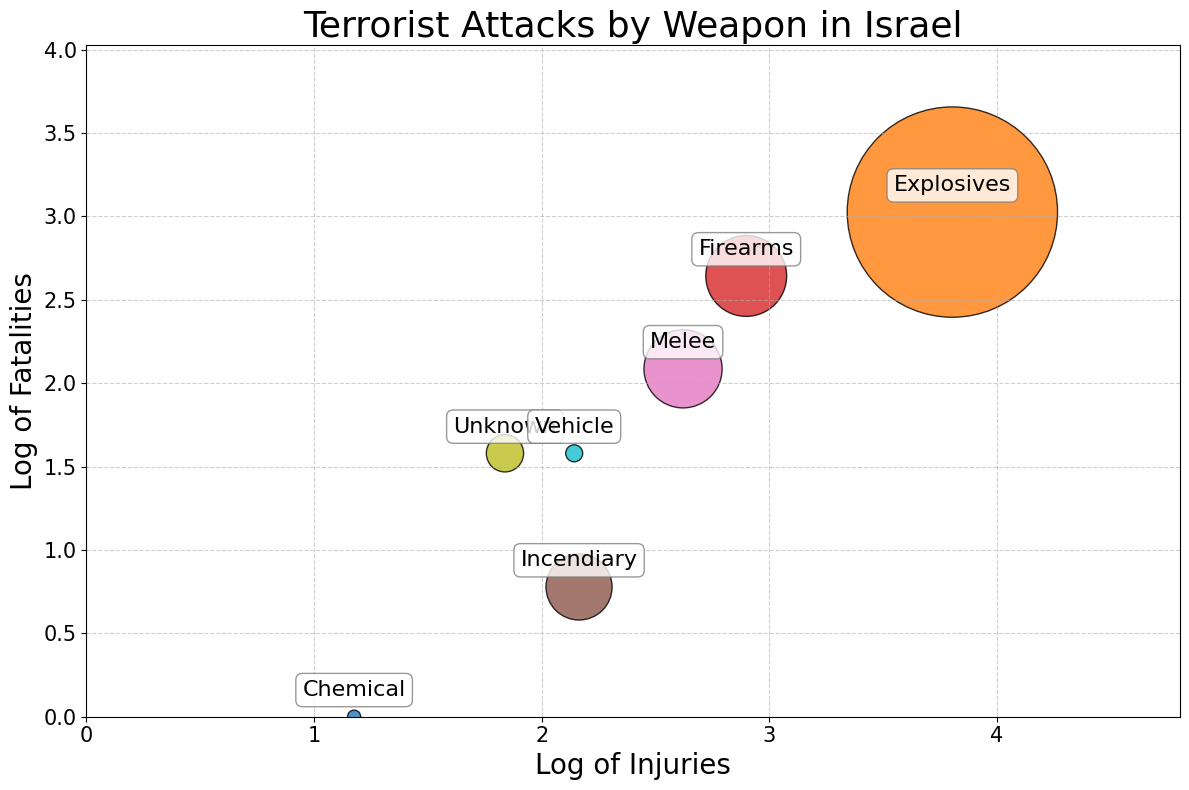

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Load the data (adjust the file path as necessary)
# Load and process the dataset
file_path = 'IL_data.csv'  # Adjust this path as necessary
terror_data = pd.read_csv(file_path, encoding='ISO-8859-1',
                          usecols=['eventid', 'iyear', 'imonth', 'iday', 'country_txt', 'provstate',
                                   'targtype1_txt', 'weaptype1_txt', 'nkill', 'nwound'])

# Rename columns for consistency
terror_data = terror_data.rename(
    columns={
        'eventid': 'id',
        'iyear': 'year',
        'imonth': 'month',
        'iday': 'day',
        'country_txt': 'country',
        'provstate': 'state',
        'targtype1_txt': 'target',
        'weaptype1_txt': 'weapon',
        'nkill': 'fatalities',
        'nwound': 'injuries'
    }
)

# Fill missing values in 'fatalities' and 'injuries' with 0 and convert to integers
terror_data['fatalities'] = terror_data['fatalities'].fillna(0).astype(int)
terror_data['injuries'] = terror_data['injuries'].fillna(0).astype(int)

group_threshold = 5  # Minimum number of incidents to have its own category
weapon_summary = terror_data['weapon'].value_counts()
major_categories = weapon_summary[weapon_summary >= group_threshold].index.tolist()
terror_data['weapon_grouped'] = terror_data['weapon'].apply(
    lambda x: x if x in major_categories else 'Others'
)

# Recalculate statistics for grouped categories
grouped_data = terror_data.groupby('weapon_grouped').agg(
    incidents=('id', 'count'),
    fatalities=('fatalities', 'sum'),
    injuries=('injuries', 'sum')
).reset_index()

# Replace "Vehicle" string with a shortened version and exclude "Others"
grouped_data['weapon_grouped'] = grouped_data['weapon_grouped'].replace(
    {'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': 'Vehicle'}
)
grouped_data = grouped_data[grouped_data['weapon_grouped'] != 'Others']  # Exclude "Others"

# Reset index to ensure alignment
grouped_data = grouped_data.reset_index(drop=True)
grouped_categories = grouped_data['weapon_grouped']
grouped_fatalities = np.log10(grouped_data['fatalities'] + 1)  # Log scale
grouped_injuries = np.log10(grouped_data['injuries'] + 1)  # Log scale
grouped_incidents = grouped_data['incidents']

# Assign colors to groups
colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_categories)))  # Generate distinct colors
grouped_data['color'] = [colors[i] for i in range(len(grouped_categories))]  # Assign 1D colors array

# Scatter plot with increased grid range
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    grouped_injuries,
    grouped_fatalities,
    s=grouped_incidents * 15,  # Size proportional to incidents
    alpha=0.8,
    c=grouped_data['color'],
    edgecolors='black'
)

# Add labels above each bubble
for i, category in enumerate(grouped_categories):
    ax.text(
        grouped_injuries.iloc[i],
        grouped_fatalities.iloc[i] + 0.1,  # Adjusted to appear above the bubble
        category,
        fontsize=16,
        ha='center',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8)
    )

# Customize axes
ax.set_title("Terrorist Attacks by Weapon in Israel", fontsize=26)
ax.set_xlabel("Log of Injuries", fontsize=20)
ax.set_ylabel("Log of Fatalities", fontsize=20)

# Increase the grid range
x_max = np.max(grouped_injuries) + 1  # Add extra space to the right
y_max = np.max(grouped_fatalities) + 1  # Add extra space to the top
ax.set_xlim([0, x_max])
ax.set_ylim([0, y_max])

ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)


# Add gridlines for better visibility
ax.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

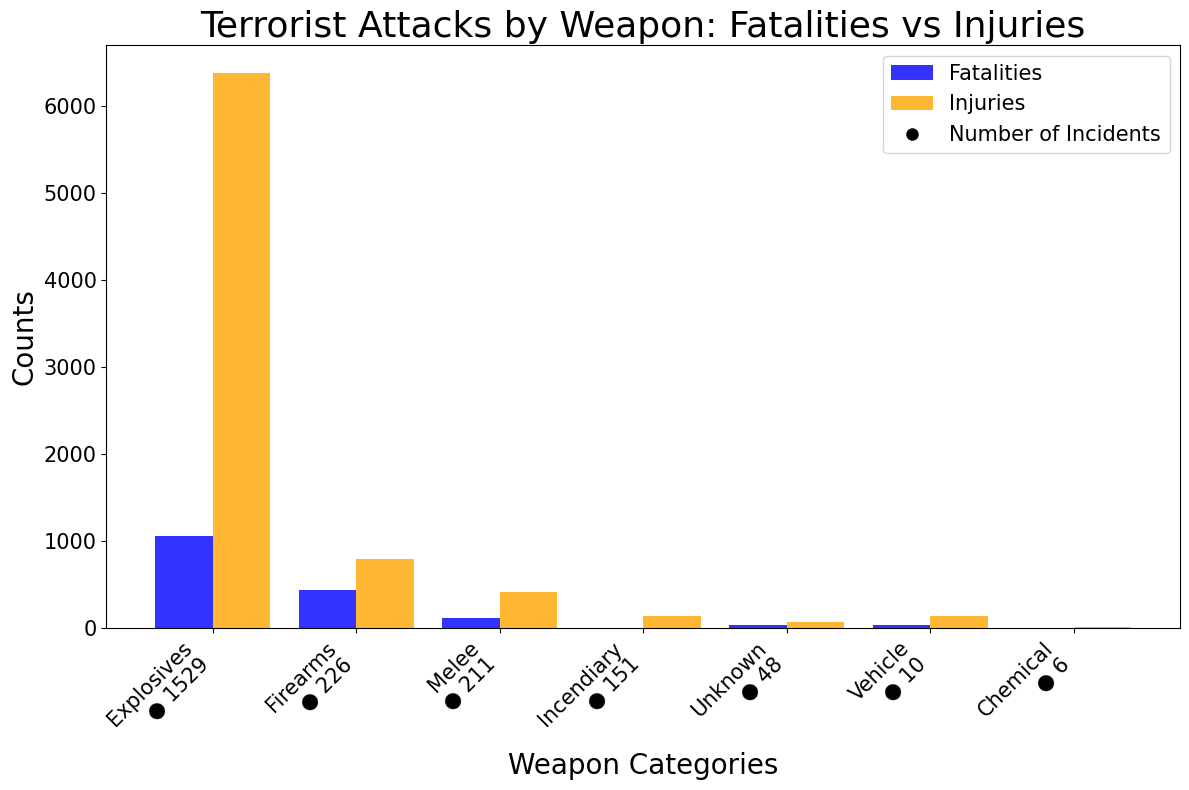

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the data by the number of incidents (bubble size)
sorted_data = grouped_data.sort_values(by='incidents', ascending=False)

# Prepare data for the bar plot
categories = sorted_data['weapon_grouped']
fatalities = sorted_data['fatalities']
injuries = sorted_data['injuries']
incidents = sorted_data['incidents']
indices = np.arange(len(categories))  # Indices for the bars

# Bar width
bar_width = 0.4

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot fatalities and injuries
bars_fatalities = ax.bar(indices - bar_width / 2, fatalities, bar_width, label='Fatalities', color='blue', alpha=0.8)
bars_injuries = ax.bar(indices + bar_width / 2, injuries, bar_width, label='Injuries', color='orange', alpha=0.8)

# Add category labels with dots next to the numbers
category_labels = [f"{cat}\n● {inc}" for cat, inc in zip(categories, incidents)]
ax.set_xticks(indices)
ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)


# Add labels and title
ax.set_xlabel('Weapon Categories', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('Terrorist Attacks by Weapon: Fatalities vs Injuries', fontsize=26)

# Add the legend for fatalities, injuries, and the dot
dot_legend = plt.Line2D([0], [0], marker='o', color='black', label='Number of Incidents', markersize=8, linestyle='None')
ax.legend(handles=[bars_fatalities, bars_injuries, dot_legend], loc='upper right', fontsize=15)

# Show plot
plt.tight_layout()
plt.show()
